In [2]:
from torchvision import datasets
from torchvision.transforms import ToTensor


In [3]:
train_data = datasets.MNIST(
    root='data',
    train = True,
    transform=ToTensor(),
    download = True
)

test_data = datasets.MNIST(
    root='data',
    train = False,
    transform=ToTensor(),
    download = True
)

In [4]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [5]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [6]:
train_data.data

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0,

In [7]:
train_data.data.shape

torch.Size([60000, 28, 28])

In [8]:
test_data.data.shape

torch.Size([10000, 28, 28])

In [9]:
train_data.targets.size()

torch.Size([60000])

In [10]:
train_data.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

In [11]:
from torch.utils.data import DataLoader

loaders = {
    'train': DataLoader(train_data, batch_size=100, shuffle=True, num_workers=1),
    'test': DataLoader(test_data, batch_size=100, shuffle=True, num_workers=1)
}

In [12]:
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x1a11d5e6310>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x1a11dd67550>}

In [13]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.softmax(x)

In [14]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN().to(device)

optimizer = optim.Adam(model.parameters(), lr=0.01)

loss_fn = nn.CrossEntropyLoss()

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(loaders['train']):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 20 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(loaders["train"].dataset)} ({100. * batch_idx / len(loaders["train"]):.0f}%)]\tLoss: {loss.item():.6f}')

def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loaders['test']:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(loaders['test'].dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(loaders["test"].dataset)} ({100. * correct / len(loaders["test"].dataset):.0f}%)\n')    

In [15]:
device

device(type='cpu')

In [16]:
for epoch in range(1, 11):
    train(epoch)
    test()

C:\Users\dhruv\AppData\Local\Temp\ipykernel_21064\2530090726.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.303684
Train Epoch: 1 [2000/60000 (3%)]	Loss: 2.203210
Train Epoch: 1 [4000/60000 (7%)]	Loss: 1.970510
Train Epoch: 1 [6000/60000 (10%)]	Loss: 1.983889
Train Epoch: 1 [8000/60000 (13%)]	Loss: 1.839723
Train Epoch: 1 [10000/60000 (17%)]	Loss: 1.842676
Train Epoch: 1 [12000/60000 (20%)]	Loss: 1.848570
Train Epoch: 1 [14000/60000 (23%)]	Loss: 1.790186
Train Epoch: 1 [16000/60000 (27%)]	Loss: 1.694074
Train Epoch: 1 [18000/60000 (30%)]	Loss: 1.719970
Train Epoch: 1 [20000/60000 (33%)]	Loss: 1.717210
Train Epoch: 1 [22000/60000 (37%)]	Loss: 1.749731
Train Epoch: 1 [24000/60000 (40%)]	Loss: 1.705507
Train Epoch: 1 [26000/60000 (43%)]	Loss: 1.731075
Train Epoch: 1 [28000/60000 (47%)]	Loss: 1.828532
Train Epoch: 1 [30000/60000 (50%)]	Loss: 1.623957
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.791471
Train Epoch: 1 [34000/60000 (57%)]	Loss: 1.672251
Train Epoch: 1 [36000/60000 (60%)]	Loss: 1.716316
Train Epoch: 1 [38000/60000 (63%)]	Loss: 1.715212
Train Epoch

In [17]:
device

device(type='cpu')

Prediction: 2


C:\Users\dhruv\AppData\Local\Temp\ipykernel_21064\2530090726.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


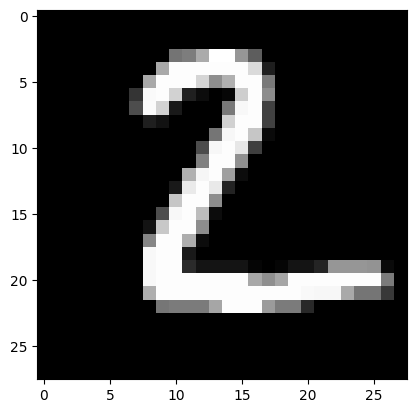

In [26]:
import  matplotlib.pyplot as plt

model.eval()

data, target = test_data[1]

data = data.unsqueeze(0).to(device)

output = model(data)

prediction = output.argmax(dim=1, keepdim=True).item()

print(f'Prediction: {prediction}')

image = data.squeeze(0).squeeze(0).cpu().numpy()

plt.imshow(image, cmap='gray')
plt.show()

In [33]:
test_data[1]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.4549, 0.4902, 0.6706, 1.0000, 1.0000, 0.5882,
           0.3647, 0.0000, 0.0000, 0.0000, 